In [1]:
!!pip install tensorflow

['Requirement already satisfied: tensorflow in /usr/local/lib/python3.11/dist-packages (2.18.0)',
 'Requirement already satisfied: absl-py>=1.0.0 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (1.4.0)',
 'Requirement already satisfied: astunparse>=1.6.0 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (1.6.3)',
 'Requirement already satisfied: flatbuffers>=24.3.25 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (25.2.10)',
 'Requirement already satisfied: gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (0.6.0)',
 'Requirement already satisfied: google-pasta>=0.1.1 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (0.2.0)',
 'Requirement already satisfied: libclang>=13.0.0 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (18.1.1)',
 'Requirement already satisfied: opt-einsum>=2.3.2 in /usr/local/lib/python3.11/dist-packages (from tensorflow) (3.4.0)',
 'Requirement already sati

In [2]:
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm as tq
import pathlib
import gdown
import zipfile
import numpy as np
import random

In [3]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
from keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam

# Load Data

In [4]:
# ID file Google Drive
file_id = '1a1wuqIntWWd36fFVhVSFXkaEfRp8Q4Wr'
zip_name = 'combine_data.zip'

# Download file dari Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', zip_name, quiet=False)

# Buat folder untuk ekstrak
extract_path = 'combine_data'
os.makedirs(extract_path, exist_ok=True)

# Ekstrak ZIP
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Lihat isi folder
os.listdir(extract_path)


Downloading...
From (original): https://drive.google.com/uc?id=1a1wuqIntWWd36fFVhVSFXkaEfRp8Q4Wr
From (redirected): https://drive.google.com/uc?id=1a1wuqIntWWd36fFVhVSFXkaEfRp8Q4Wr&confirm=t&uuid=27781a13-f068-4c26-85b9-120f4f033a34
To: /content/combine_data.zip
100%|██████████| 1.78G/1.78G [00:19<00:00, 90.9MB/s]


['Bercak_daun_Septoria',
 'powdery_mildew',
 'Sehat',
 'Jamur_daun',
 'Busuk_daun_lanjut',
 'Bercak_target',
 'Tungau_dua_bercak',
 'Embun_tepung',
 'Virus_keriting_daun_kuning',
 'Busuk_daun_awal',
 'Virus_mosaik_tomat',
 'Bercak_bakteri']

# Modelling

In [5]:
mypath = "combine_data"

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
Bercak_bakteri,3858
Bercak_daun_Septoria,3878
Bercak_target,3884
Busuk_daun_awal,3898
Busuk_daun_lanjut,3905
Embun_tepung,3906
Jamur_daun,3893
Sehat,3856
Tungau_dua_bercak,3882


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42684 entries, 0 to 42683
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   path       42684 non-null  object
 1   file_name  42684 non-null  object
 2   labels     42684 non-null  object
dtypes: object(3)
memory usage: 1000.5+ KB


In [7]:
X= df['path']
y= df['labels']

#Split Data Training:Validation:Testing = 70:15:15

# Split 15% untuk test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Dari 85% data sisa, ambil 15/85 ≈ 0.176 untuk validation, sisanya jadi train
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)


In [8]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_tr, df_val, df_te]).reset_index(drop=True)

In [9]:
# Print hasil untuk melihat panjang size data training, validation, dan testing
print('Train size:', len(df_tr))
print('Validation size:', len(df_val))
print('Test size:', len(df_te))


Train size: 29895
Validation size: 6386
Test size: 6403


In [10]:
# Gabungkan semuanya menjadi satu DataFrame akhir
df_all = pd.concat([df_tr, df_val, df_te]).reset_index(drop=True)

In [11]:
# Gabungkan DataFrame df_tr, df_val, dan df_te
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))



set    labels                    
test   Bercak_bakteri                 579
       Bercak_daun_Septoria           582
       Bercak_target                  583
       Busuk_daun_awal                585
       Busuk_daun_lanjut              586
       Embun_tepung                   586
       Jamur_daun                     584
       Sehat                          578
       Tungau_dua_bercak              582
       Virus_keriting_daun_kuning     575
       Virus_mosaik_tomat             583
train  Bercak_bakteri                2702
       Bercak_daun_Septoria          2716
       Bercak_target                 2720
       Busuk_daun_awal               2730
       Busuk_daun_lanjut             2735
       Embun_tepung                  2736
       Jamur_daun                    2726
       Sehat                         2701
       Tungau_dua_bercak             2719
       Virus_keriting_daun_kuning    2688
       Virus_mosaik_tomat            2722
val    Bercak_bakteri                 577

In [12]:
datasource_path = "combine_data"
dataset_path = "Dataset-Final/"

In [13]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
      file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [14]:
# Define training, validation, and test directories
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/val/"
TEST_DIR = "Dataset-Final/test/"


In [15]:
# Augmentasi data training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing data validation
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Preprocessing data test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Membuat generator data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 29895 images belonging to 11 classes.
Found 6386 images belonging to 11 classes.
Found 6403 images belonging to 11 classes.


In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
feature_extractor = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
])

model = Sequential([
    feature_extractor,
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),

    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(11, activation='softmax')
])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,834,827 (110.00 MB)

 Trainable params: 14,177,675 (54.08 MB)

 Non-trainable params: 14,657,152 (55.91 MB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
class AccuracyThresholdStopping(Callback):
    def __init__(self, target_accuracy=0.96):
        super().__init__()
        self.target_accuracy = target_accuracy
        self.last_train_accuracy = 0
        self.last_val_accuracy = 0

    def on_epoch_end(self, epoch, logs=None):
        self.last_val_accuracy = logs.get('val_accuracy')
        self.last_train_accuracy = logs.get('accuracy')

        if self.last_val_accuracy is not None and self.last_train_accuracy is not None:
            if self.last_val_accuracy >= self.target_accuracy and self.last_train_accuracy >= self.target_accuracy:
                print(f"\nTraining dan Validation accuracy sudah mencapai {self.target_accuracy*100:.1f}%, menghentikan training.")
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        print(f"\nAkurasi terakhir Training: {self.last_train_accuracy*100:.2f}%")
        print(f"Akurasi terakhir Validation: {self.last_val_accuracy*100:.2f}%")

# EarlyStopping berdasarkan akurasi, kalau tidak meningkat
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, min_delta=0.01)

# Reduce learning rate jika akurasi validasi tidak meningkat
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0001)

# Custom Callback untuk target 95%
accuracy_stop = AccuracyThresholdStopping(target_accuracy=0.96)

In [18]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

# Fit model dengan callbacks yang sudah disesuaikan
hist = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping,accuracy_stop,reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/step - accuracy: 0.5817 - loss: 2.5719 - val_accuracy: 0.8029 - val_loss: 2.3500 - learning_rate: 0.0010
Epoch 2/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.8849 - loss: 1.1418 - val_accuracy: 0.9129 - val_loss: 0.8439 - learning_rate: 0.0010
Epoch 3/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.9188 - loss: 0.7396 - val_accuracy: 0.9223 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 4/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.9318 - loss: 0.5529 - val_accuracy: 0.9175 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 5/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - accuracy: 0.9447 - loss: 0.4272 - val_accuracy: 0.9439 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 6/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 486s 2s/step - accuracy: 0.9501 - loss: 0.3648 - val_accuracy: 0.9331 - val_loss: 0.4094 - learning_rate: 0.0010
Epoch 7/15
234/234 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.9488 - loss: 0.

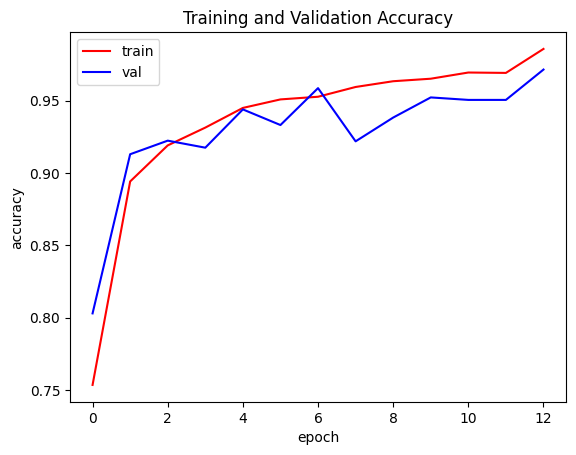

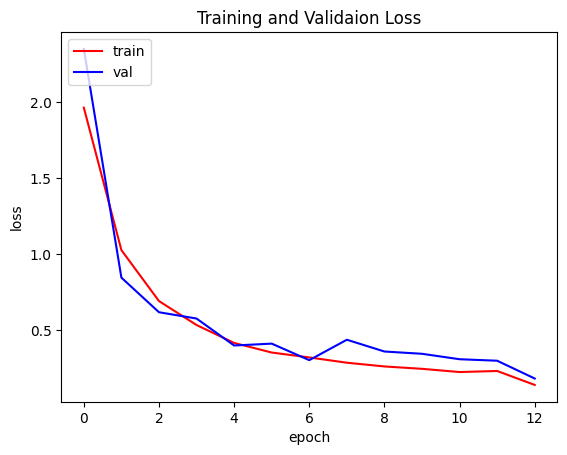

In [20]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [21]:
# Evaluasi model menggunakan data test
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 541ms/step - accuracy: 0.9742 - loss: 0.1663
Loss: 0.1636
Accuracy: 0.9756


## Konversi Model

### Saved Model

In [22]:
# Simpan model ke dalam folder 'saved_model_Resnet50'
save_path = os.path.join("saved_model_Resnet50")
tf.saved_model.save(model, save_path)

In [23]:
# Zip folder model
!zip -r saved_model_Resnet50.zip saved_model_Resnet50

  adding: saved_model_Resnet50/ (stored 0%)
  adding: saved_model_Resnet50/fingerprint.pb (stored 0%)
  adding: saved_model_Resnet50/assets/ (stored 0%)
  adding: saved_model_Resnet50/variables/ (stored 0%)
  adding: saved_model_Resnet50/variables/variables.index (deflated 80%)
  adding: saved_model_Resnet50/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model_Resnet50/saved_model.pb (deflated 93%)


In [24]:
from google.colab import files
files.download('saved_model_Resnet50.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFJS

In [25]:
model.save("model.h5")

In [26]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-21 04:02:54.011611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747800174.032706   28840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

In [27]:
# Zip folder tfjs_model dengan nama tfjs_model_Resnet50.zip
!zip -r tfjs_model_Resnet50.zip tfjs_model

# Lihat isi dan ukuran file zip (opsional)
!ls -l tfjs_model_Resnet50.zip

# Unduh file zip
from google.colab import files
files.download('tfjs_model_Resnet50.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard24of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard14of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard7of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard13of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of28.bin (deflated 6%)
  adding: tfjs_model/group1-shard18of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard28of28.bin (deflated 8%)
  adding: tfjs_model/group1-shard17of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard5of28.bin (deflated 6%)
  adding: tfjs_model/group1-shard27of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard23of28.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard26of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard20of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard10of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard19of28.bin (deflated 7%)
  adding: tfjs_model/group1-shard9of28.bin (deflated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TF-Lite

In [28]:
# 1. Convert SavedModel ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model_Resnet50')  # ganti sesuai nama folder yang benar
tflite_model = converter.convert()

# 2. Buat folder 'tflite/'
os.makedirs('tflite', exist_ok=True)

# 3. Simpan model.tflite di dalam tflite/
tflite_model_path = pathlib.Path('tflite/model.tflite')
tflite_model_path.write_bytes(tflite_model)

279884

In [29]:
# 4. Simpan label.txt di dalam tflite/
labels = list(train_generator.class_indices.keys())
with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")


In [30]:
# 5. Zip folder tflite dengan nama yang sesuai
!zip -r tflite_Resnet50.zip tflite

# 6. Download file zip
files.download('tflite_Resnet50.zip')

  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 83%)
  adding: tflite/label.txt (deflated 34%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference Model

In [31]:
# Path folder data dan model
base_dir = 'combine_data'
model_path = 'saved_model_Resnet50'

# Load model
model = tf.saved_model.load(model_path)
infer = model.signatures["serving_default"]

# List semua kelas
kelas_list = os.listdir(base_dir)
kelas_list.sort()

# Jumlah gambar yang akan dicek?
jumlah_gambar = 10

for i in range(jumlah_gambar):
    # --- Ambil gambar random ---
    kelas_random = random.choice(kelas_list)
    kelas_path = os.path.join(base_dir, kelas_random)
    gambar_random = random.choice(os.listdir(kelas_path))
    gambar_path = os.path.join(kelas_path, gambar_random)

    # --- Load gambar ---
    img = load_img(gambar_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # --- Prediksi ---
    input_tensor = tf.convert_to_tensor(img_array)
    prediction = infer(input_tensor)

    # Ambil output prediksi
    for key in prediction.keys():
        output = prediction[key]
        break

    predicted_index = np.argmax(output.numpy(), axis=-1)[0]
    predicted_class_name = kelas_list[predicted_index]

    # --- Print hasil ---
    print("="*50)
    print(f"[{i+1}]")
    print(f"Gambar dipilih : {gambar_path}")
    print(f"Hasil Prediksi : {predicted_class_name}")


[1]
Gambar dipilih : combine_data/Virus_mosaik_tomat/1ccfd473-6b3d-47a9-897b-0653d7683d75___PSU_CG 2163_270deg.JPG
Hasil Prediksi : Virus_mosaik_tomat
[2]
Gambar dipilih : combine_data/Sehat/4bd918e2-ac0a-41b4-b1a0-f1bb799a309c___RS_HL 9846.JPG
Hasil Prediksi : Sehat
[3]
Gambar dipilih : combine_data/Jamur_daun/6bc4a7d2-eaf3-41d4-8129-3165658288d4___Crnl_L.Mold 8766.JPG
Hasil Prediksi : Jamur_daun
[4]
Gambar dipilih : combine_data/Busuk_daun_awal/c2a64948-bda7-4a89-aec6-be714ba7cf99___RS_Erly.B 8330_flipTB.JPG
Hasil Prediksi : Busuk_daun_awal
[5]
Gambar dipilih : combine_data/Busuk_daun_lanjut/Lb96_hight.jpg
Hasil Prediksi : Busuk_daun_lanjut
[6]
Gambar dipilih : combine_data/Embun_tepung/pm70_mirror_vertical.jpg
Hasil Prediksi : Embun_tepung
[7]
Gambar dipilih : combine_data/Virus_mosaik_tomat/tomato-mosaic-virus-F0BA26_jpg.rf.3153afdd5cbdf7ac3d98c9e1c9a4ec9d.jpg
Hasil Prediksi : Virus_mosaik_tomat
[8]
Gambar dipilih : combine_data/Embun_tepung/pm5_lower.jpg
Hasil Prediksi : Embun_tep

[1]
Gambar dipilih : combine_data/Virus_keriting_daun_kuning/d8720cd3-297c-4914-9088-bfd7743db455___UF.GRC_YLCV_Lab 09581.JPG
Hasil Prediksi : Virus_keriting_daun_kuning


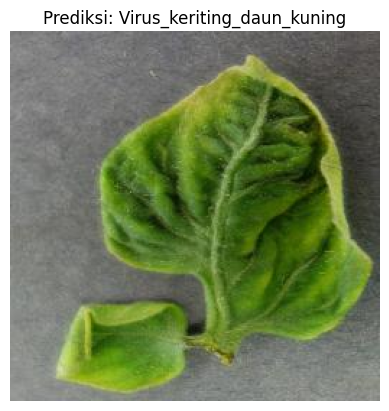

[2]
Gambar dipilih : combine_data/Busuk_daun_lanjut/6578c88a-fd14-450b-8e75-c94571decf83___GHLB2 Leaf 8849.JPG
Hasil Prediksi : Busuk_daun_lanjut


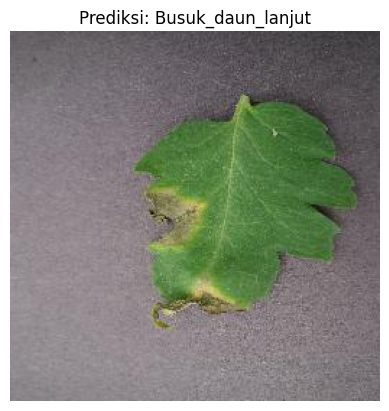

[3]
Gambar dipilih : combine_data/Bercak_bakteri/6c300ff6-c94d-4065-8354-73a141b1b3d5___GCREC_Bact.Sp 3382.JPG
Hasil Prediksi : Bercak_bakteri


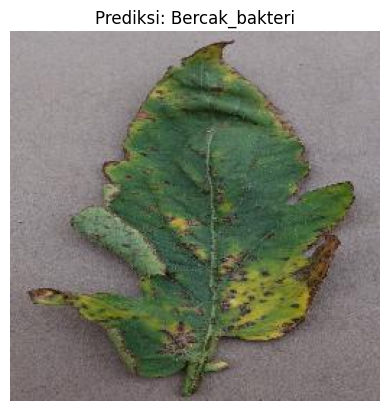

[4]
Gambar dipilih : combine_data/Bercak_bakteri/Bs8_mirror_vertical.jpg
Hasil Prediksi : Bercak_bakteri


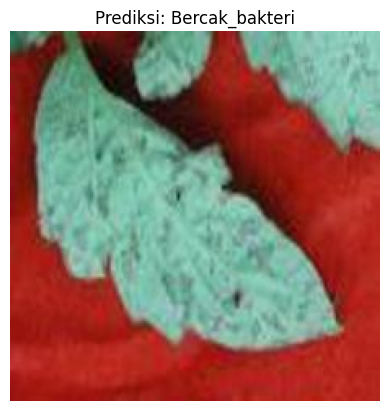

[5]
Gambar dipilih : combine_data/Busuk_daun_lanjut/LateBlight-Tomato-JJ-2009-17nxg4q_jpg.rf.82bdce54121b2cd0d2538bc54d7eb1a6.jpg
Hasil Prediksi : Busuk_daun_lanjut


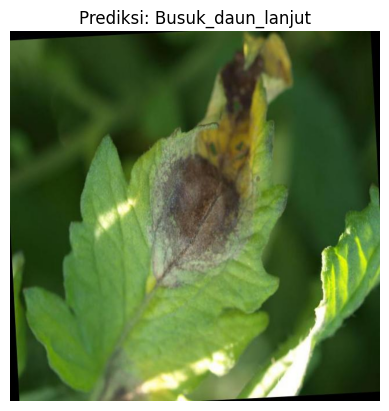

[6]
Gambar dipilih : combine_data/Jamur_daun/a0e635a0-0935-4192-94cf-7003875a501e___Crnl_L.Mold 8675_180deg.JPG
Hasil Prediksi : Jamur_daun


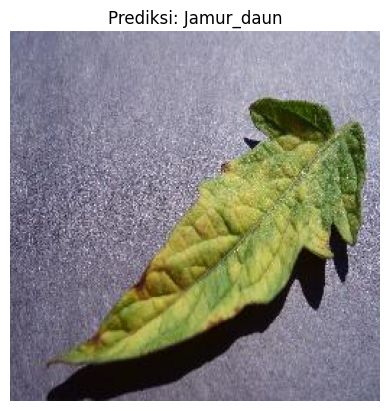

[7]
Gambar dipilih : combine_data/Bercak_target/0f5f2efc-3544-4fbc-8dcc-e623577596bc___Com.G_TgS_FL 9869_aug319.jpg
Hasil Prediksi : Bercak_target


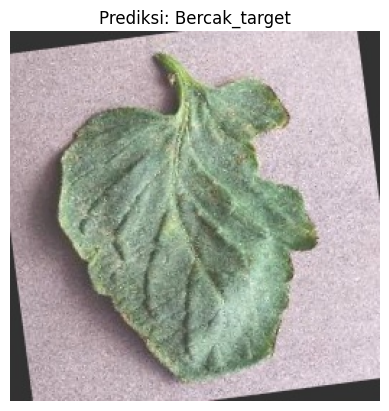

[8]
Gambar dipilih : combine_data/Tungau_dua_bercak/a461c5ba-c3c2-415c-a72e-10f8e6b49613___Com.G_SpM_FL 1780.JPG
Hasil Prediksi : Tungau_dua_bercak


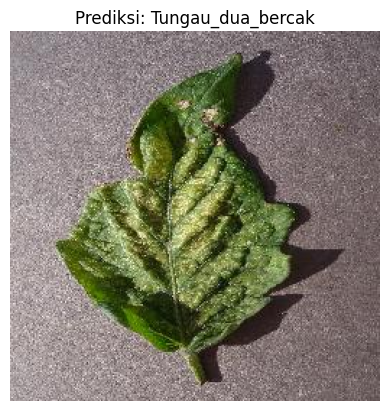

[9]
Gambar dipilih : combine_data/Tungau_dua_bercak/4a6a93a5-d51c-4769-8669-12ec54d87ce6___Com.G_SpM_FL 9441_180deg.JPG
Hasil Prediksi : Tungau_dua_bercak


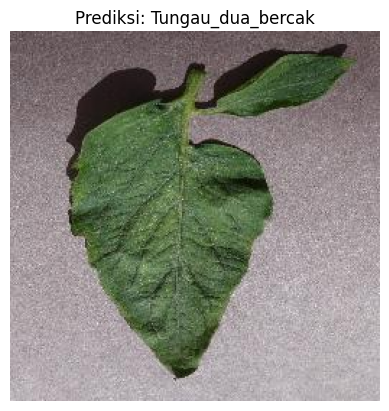

[10]
Gambar dipilih : combine_data/Tungau_dua_bercak/edd90a56-3a0f-4b3c-a55e-0e0a73bdf18d___Com.G_SpM_FL 1689_aug866.jpg
Hasil Prediksi : Tungau_dua_bercak


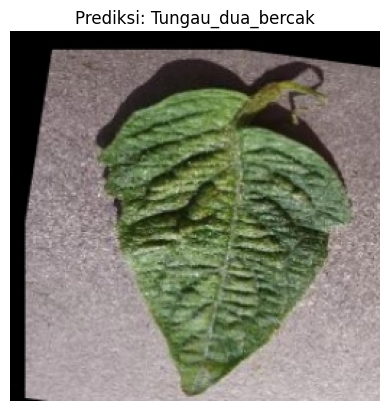

In [32]:
# Path folder data dan model
base_dir = 'combine_data'
model_path = 'saved_model_Resnet50'

# Load model
model = tf.saved_model.load(model_path)
infer = model.signatures["serving_default"]

# List semua kelas
kelas_list = os.listdir(base_dir)
kelas_list.sort()

# Jumlah gambar yang akan dicek
jumlah_gambar = 10

for i in range(jumlah_gambar):
    # --- Ambil gambar random ---
    kelas_random = random.choice(kelas_list)
    kelas_path = os.path.join(base_dir, kelas_random)
    gambar_random = random.choice(os.listdir(kelas_path))
    gambar_path = os.path.join(kelas_path, gambar_random)

    # --- Load gambar ---
    img = load_img(gambar_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # --- Prediksi ---
    input_tensor = tf.convert_to_tensor(img_array)
    prediction = infer(input_tensor)

    # Ambil output prediksi
    for key in prediction.keys():
        output = prediction[key]
        break

    predicted_index = np.argmax(output.numpy(), axis=-1)[0]
    predicted_class_name = kelas_list[predicted_index]

    # --- Tampilkan hasil ---
    print("="*50)
    print(f"[{i+1}]")
    print(f"Gambar dipilih : {gambar_path}")
    print(f"Hasil Prediksi : {predicted_class_name}")

    # --- Tampilkan gambar ---
    plt.imshow(load_img(gambar_path))
    plt.title(f"Prediksi: {predicted_class_name}")
    plt.axis('off')
    plt.show()